# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 3
# Multiple Linear Regression, Subset Selection, Cross Validation

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately): Everett Sussman, Jan Geffert

Enrollment Status (109A, 121A, 209A, or E109A): 109A

Import libraries:

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
%matplotlib inline
sns.set_context("poster")

/Applications/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Forecasting Bike Sharing Usage

In this homework, we will focus on multiple linear regression and will explore techniques for subset selection. The specific task is to build a regression model for a bike share system that can predict the total number of bike rentals in a given day, based on attributes about the day. Such a demand forecasting model would be useful in planning the number of bikes that need to be available in the system on any given day, and also in monitoring traffic in the city. The data for this problem was collected from the Capital Bikeshare program in Washington D.C. over two years.   

The data set is provided in the files `Bikeshare_train.csv` and `Bikeshare_test.csv`, as separate training and test sets. Each row in these files contains 10 attributes describing a day and its weather:
- season (1 = spring, 2 = summer, 3 = fall, 4 = winter)
- month (1 through 12, with 1 denoting Jan)
- holiday (1 = the day is a holiday, 0 = otherwise)
- day_of_week (0 through 6, with 0 denoting Sunday)
- workingday (1 = the day is neither a holiday or weekend, 0 = otherwise)
- weather 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp (temperature in Celsius)
- atemp (apparent temperature, or relative outdoor temperature, in Celsius)
- humidity (relative humidity)
- windspeed (wind speed)

and the last column 'count' contains the response variable, i.e. total number of bike rentals on the day.


## Part (a): Data Exploration & Preprocessing

As a first step, identify important characteristics of the data using suitable visualizations when necessary. Some of the questions you may ask include (but are not limited to):

- How does the number of bike rentals vary between weekdays and weekends? 
- How about bike rentals on holidays?
- What effect does the season have on the bike rentals on a given day?
- Is the number of bike rentals lower than average when there is rain or snow?
- How does temperature effect bike rentals?
- Do any of the numeric attributes have a clear non-linear dependence with number of the bike rentals?



In [3]:
# Create Dataframes
trainDf = pd.read_csv("Bikeshare_train.csv")
testDf = pd.read_csv("Bikeshare_test.csv")

In [4]:
trainDf.head()

,Unnamed: 0,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
0,0,2,5,0,2,1,2,24,26,76.5833,0.118167,6073
1,1,4,12,0,2,1,1,15,19,73.3750,0.174129,6606
2,2,2,6,0,4,1,1,26,28,56.9583,0.253733,7363
3,3,4,12,0,0,0,1,0,4,58.6250,0.169779,2431
4,4,3,9,0,3,1,3,23,23,91.7083,0.097021,1996


In [5]:
# trainDf summary statistics
trainDf.shape

(331, 12)

In [6]:
# testDf summary statistics
testDf.shape

(400, 12)

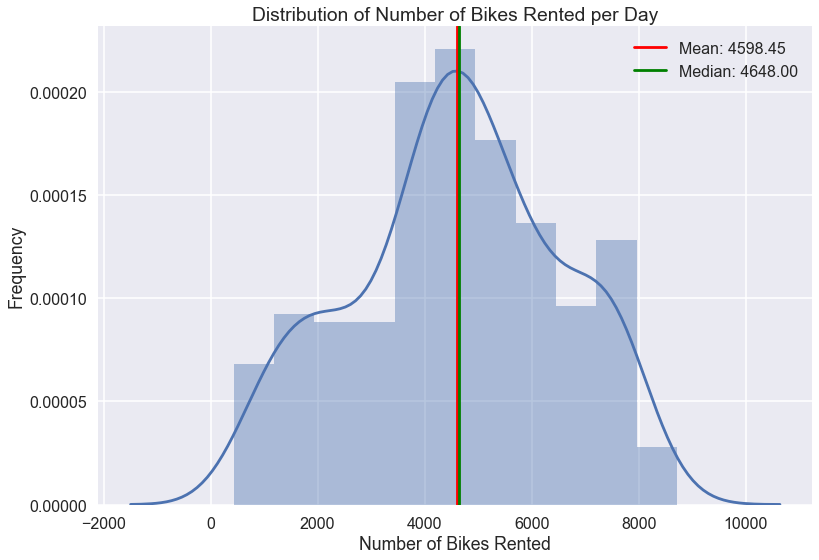

In [7]:
# General histogram of count data

meanBikesRented = np.mean(trainDf["count"])
medianBikesRented = np.median(trainDf["count"])


fig, ax = plt.subplots(1)
ax = sns.distplot(trainDf["count"])
ax.set_title("Distribution of Number of Bikes Rented per Day")
ax.set_xlabel("Number of Bikes Rented")
ax.set_ylabel("Frequency")

ax.axvline(x = meanBikesRented, color="r", label = "Mean: {0:.2f}".format(meanBikesRented))
ax.axvline(x = medianBikesRented, color="g", label = "Median: {0:.2f}".format(medianBikesRented))
ax.legend()



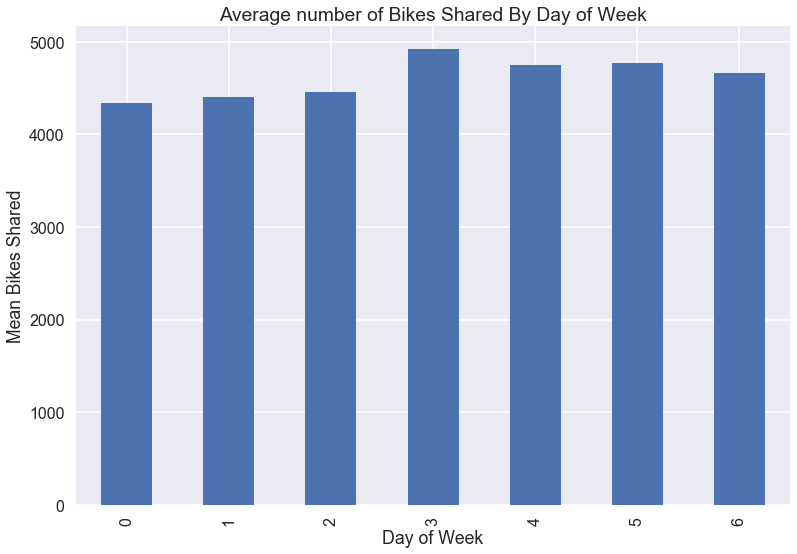

In [8]:
dayGroup = trainDf.groupby("day_of_week", as_index=True)
ax = dayGroup["count"].mean().plot(kind="bar", title="Average number of Bikes Shared By Day of Week")
ax.set_xlabel("Day of Week")
ax.set_ylabel("Mean Bikes Shared")


In [9]:
# Find mean for weekdays, mean for weekends
weekMean = np.mean(dayGroup["count"].mean()[1:-2])
weekendMean = np.mean([dayGroup["count"].mean()[0],dayGroup["count"].mean()[6]])
print("Mean Bikes Rented during the week: {}, Mean bikes Rented during the weekend: {}".format(weekMean, weekendMean))

Mean Bikes Rented during the week: 4634.760765349032, Mean bikes Rented during the weekend: 4503.6314465408805


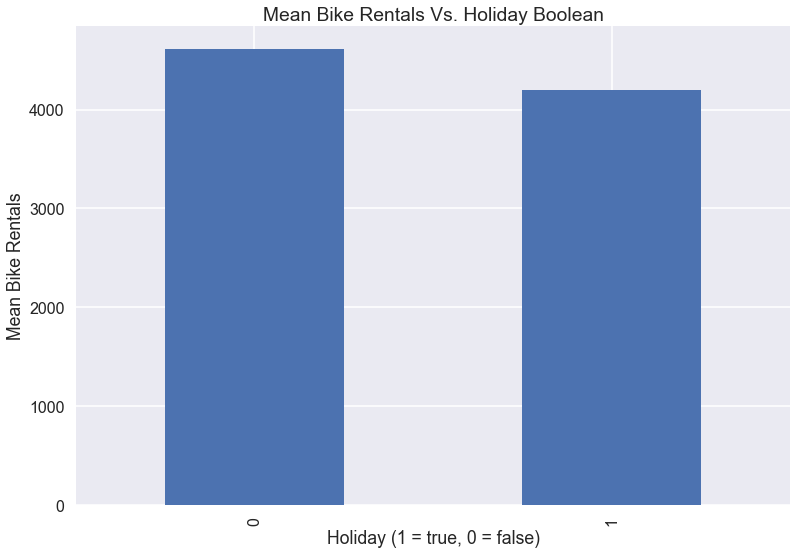

In [10]:
# Holiday Analysis
holidayGroup = trainDf.groupby("holiday")
ax = holidayGroup["count"].mean().plot(kind="bar", title="Mean Bike Rentals Vs. Holiday Boolean")
ax.set_xlabel("Holiday (1 = true, 0 = false)")
ax.set_ylabel("Mean Bike Rentals")

In [11]:
hMeans = holidayGroup["count"].mean()
print("Mean Bike Rentals during a non-Holiday: {}, Mean Bike Rentals during a Holiday: {}.".format(hMeans[0], hMeans[1]))

Mean Bike Rentals during a non-Holiday: 4612.171875, Mean Bike Rentals during a Holiday: 4199.181818181818.


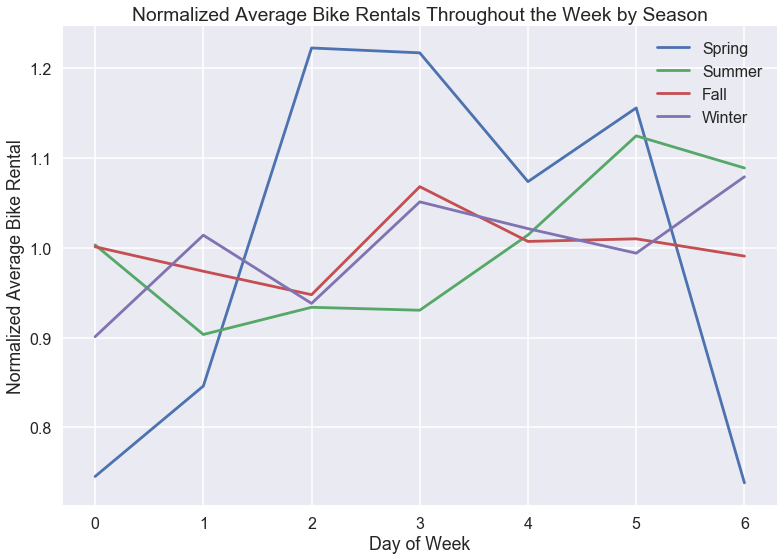

In [12]:
seasonDayGroup = trainDf.groupby(["season", "day_of_week"])["count"].mean()
fig, ax = plt.subplots(1)
seasonNames = ["Spring", "Summer", "Fall", "Winter"]
for season in range(1,5):
    mean = np.mean(seasonDayGroup[season])
    normalizedRentals = list(map(lambda x: x / mean, seasonDayGroup[season]))
    ax.plot(normalizedRentals, label=seasonNames[season-1])
    ax.legend()
    ax.set_title("Normalized Average Bike Rentals Throughout the Week by Season")
    ax.set_xlabel("Day of Week")
    ax.set_ylabel("Normalized Average Bike Rental")

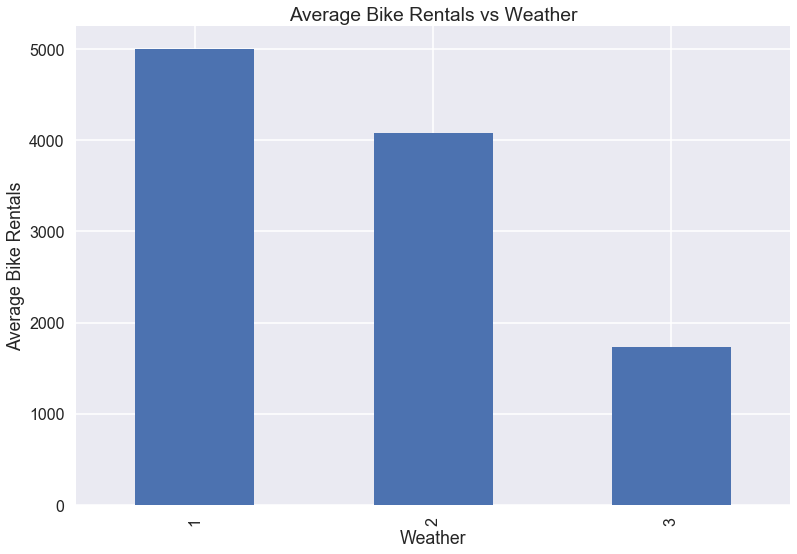

In [13]:
weatherGroup = trainDf.groupby("weather")["count"].mean()

ax = weatherGroup.plot(kind="bar", title="Average Bike Rentals vs Weather")
ax.set_xlabel("Weather")
ax.set_ylabel("Average Bike Rentals")

In [14]:
# Print out means:
for weather in range(1,4):
    weatherMean = np.mean(weatherGroup[weather])
    weatherDiff = meanBikesRented - weatherMean
    if weatherDiff < 0:
        print("Weather {} has a mean of: {}, which is {} more than the annual mean.".format(weather, weatherMean, np.abs(weatherDiff)))
    else:
        print("Weather {} has a mean of: {}, which is {} less than the annual mean.".format(weather, weatherMean, np.abs(weatherDiff)))

Weather 1 has a mean of: 5001.476415094339, which is 403.02928518497356 more than the annual mean.
Weather 2 has a mean of: 4077.1651376146788, which is 521.2819922946869 less than the annual mean.
Weather 3 has a mean of: 1736.2, which is 2862.247129909366 less than the annual mean.


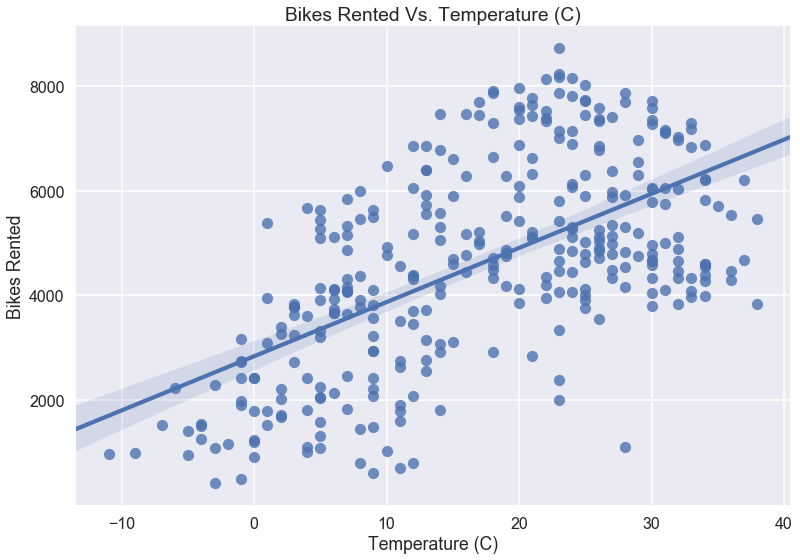

In [15]:
fig, ax = plt.subplots(1)
ax = sns.regplot(trainDf["temp"], trainDf["count"])
ax.set_title("Bikes Rented Vs. Temperature (C)")
ax.set_xlabel("Temperature (C)")
ax.set_ylabel("Bikes Rented")

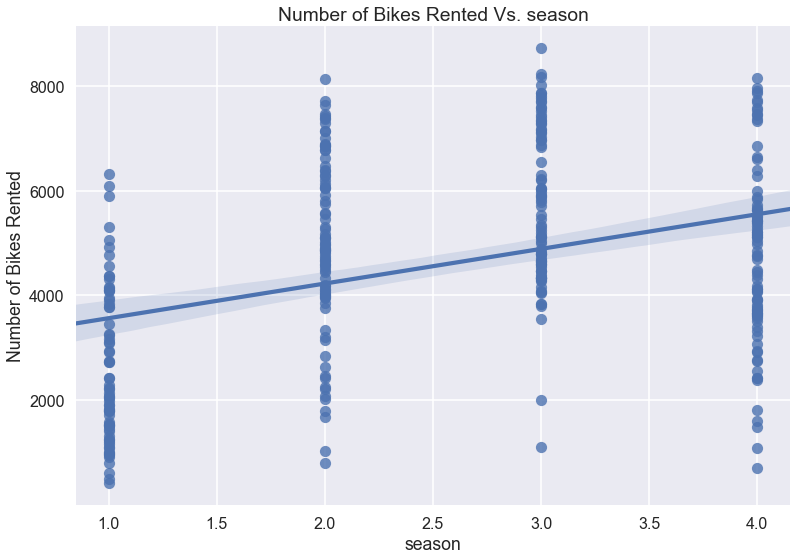

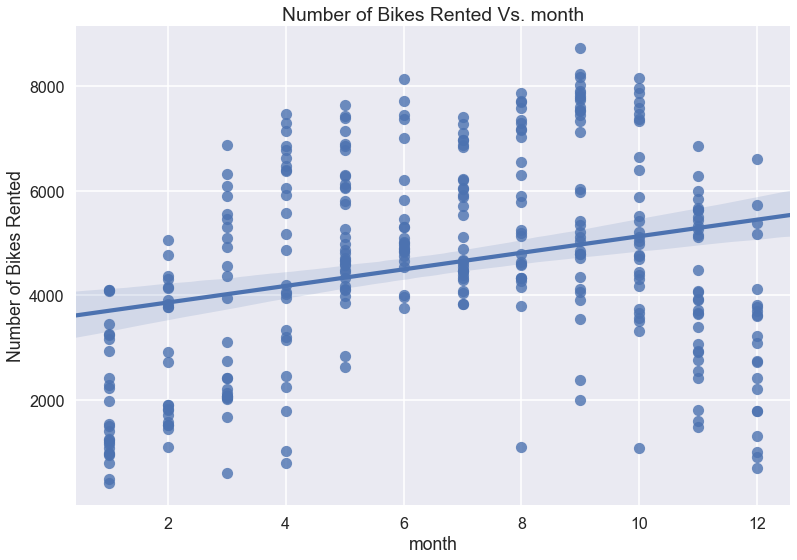

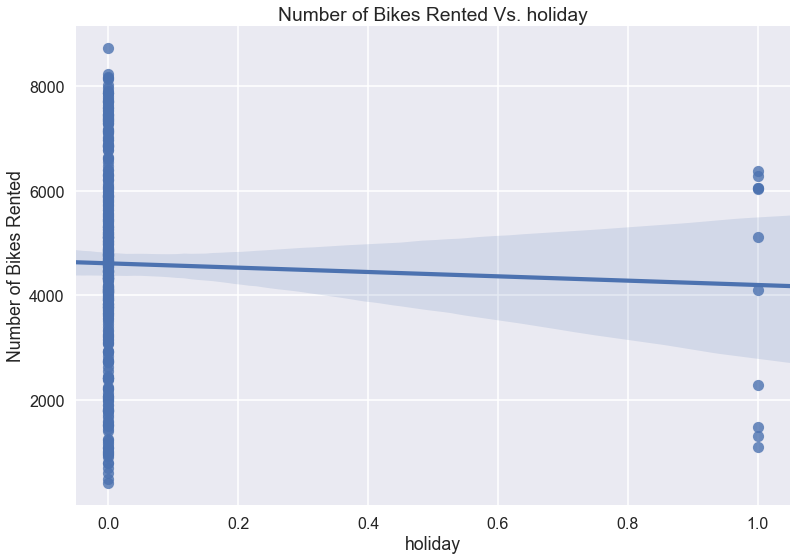

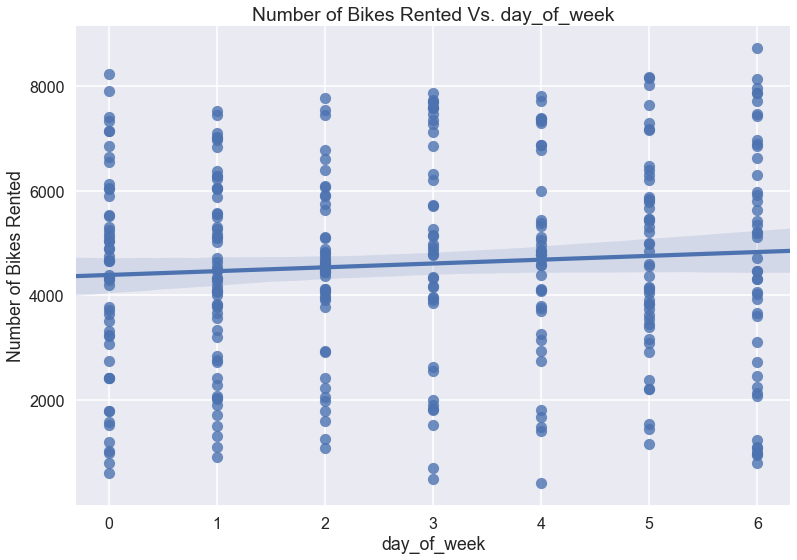

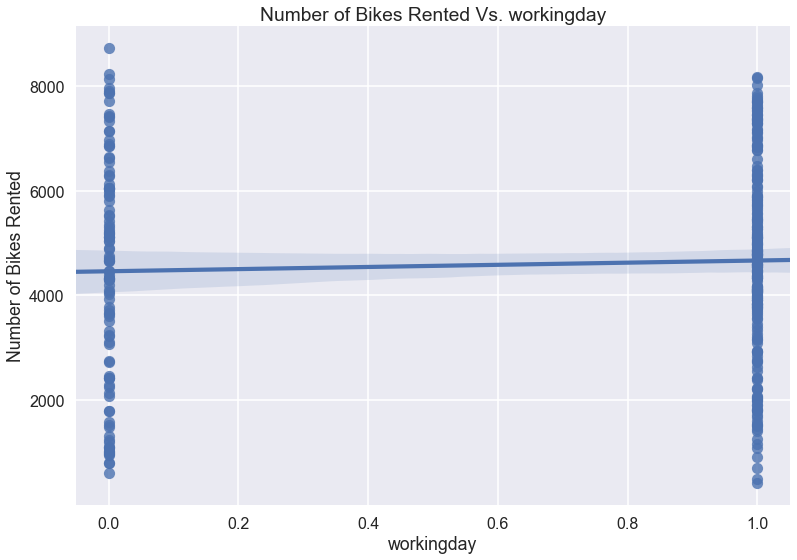

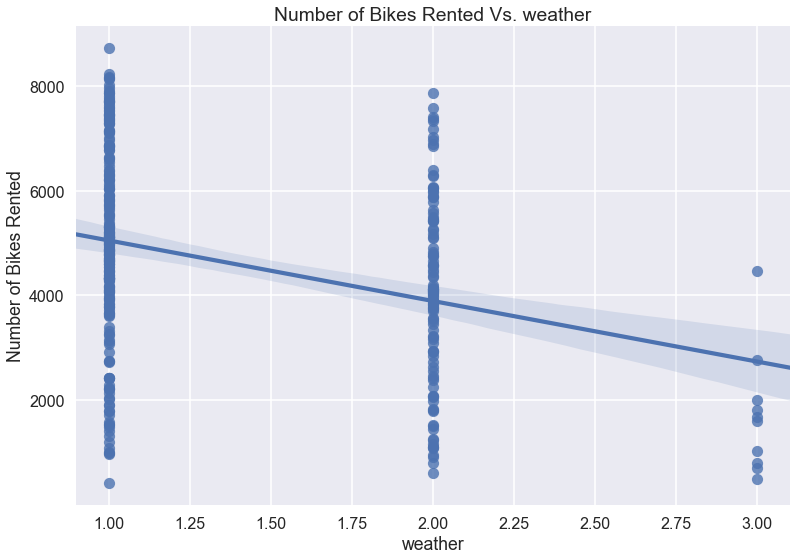

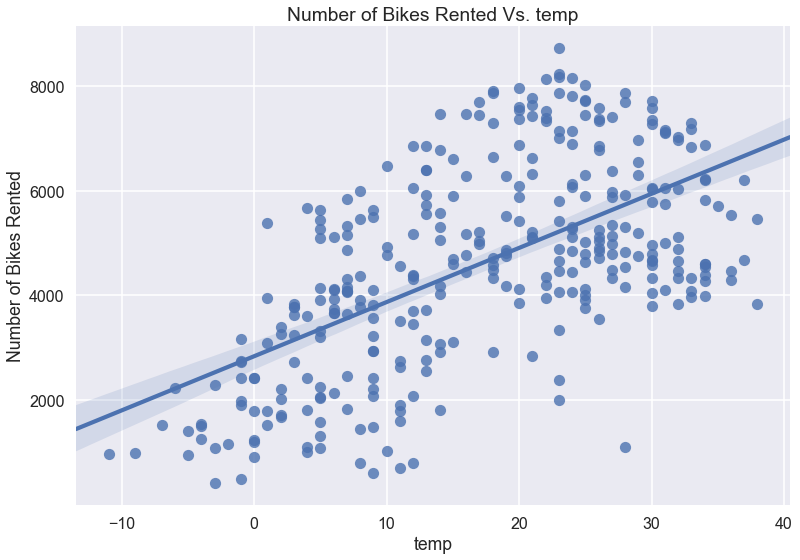

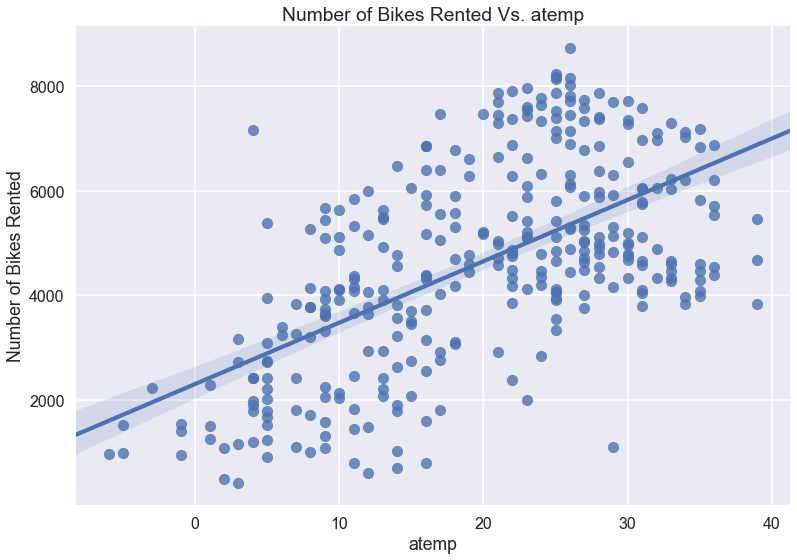

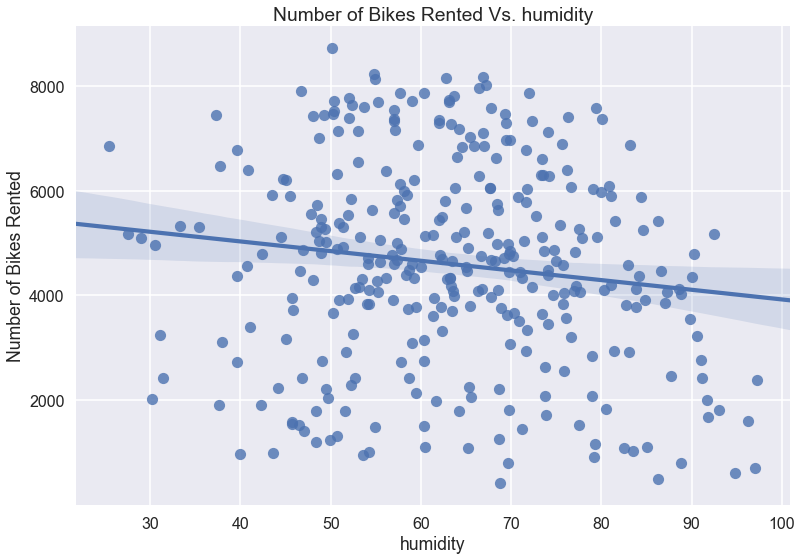

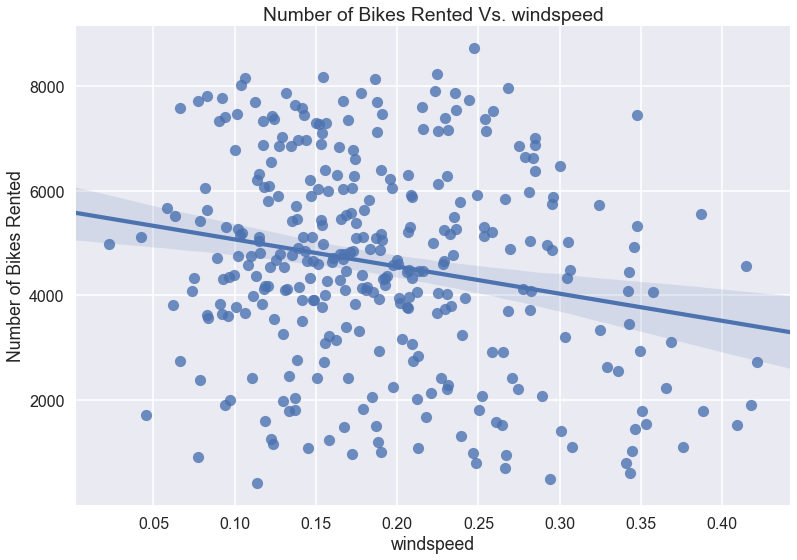

In [16]:
initPredictors = ["season", "month", "holiday", "day_of_week", "workingday", "weather", "temp", "atemp", "humidity", "windspeed"] 

for i, predictor in enumerate(initPredictors):
    fig, ax = plt.subplots()
    ax = sns.regplot(trainDf[predictor], trainDf["count"])
    ax.set_title("Number of Bikes Rented Vs. {}".format(predictor))
    ax.set_xlabel("{}".format(predictor))
    ax.set_ylabel("Number of Bikes Rented")

We next require you to pre-process the categorical and numerical attributes in the data set:

- Notice that this data set contains categorical attributes with two or more categories. **Why can't they be directly used as predictors?** Convert these categorical attributes into multiple binary attributes using one-hot encoding: in the place of every categorical attribute $x_j$ that has categories $1, \ldots, K_j$, introduce $K_j-1$ binary predictors $x_{j1}, \ldots, x_{j,K_j-1}$ where $x_{jk}$ is 1 whenever $x_j = k$ and 0 otherwise. 
** Why is it okay to not have a binary column for the $K_j$-th category? **

- Since the attributes are in different scales, it is a good practice to standardize the continuous predictors, i.e. to scale each continuous predictor to have zero mean and a standard deviation of 1. This can be done by applying the following transform to each continuous-valued predictor $j$:
$\hat{x}_{ij} = (x_{ij} - \bar{x}_j) / s_j$, where $\bar{x}_j$ and $s_j$ are the sample mean and sample standard deviation (SD) of predictor $j$ in the training set. We emphasize that the mean and SD values used for standardization must be estimated using only the training set observations, while the transform is applied to both the training and test sets. 
** Why shouldn't we include the test set observations in computing the mean and SD? **

- Provide a table of the summary statistics of the new attributes (`pd.describe()' function will help).

*Hint:* You may use the `pd.get_dummies` function to convert a categorical attribute in a data frame to one-hot encoding. This function creates $K$ binary columns for an attribute with $K$ categories. We suggest that you delete the last (or first) binary column generated by this function.

**Note:** We shall use the term "attribute" to refer to a categorical column in the data set, and the term "predictor" to refer to the individual binary columns resulting out of one-hot encoding.

In [17]:
trainBinaryDf = pd.get_dummies(trainDf, columns=["season", "month", "day_of_week", "weather"])
testBinaryDf = pd.get_dummies(testDf, columns=["season", "month", "day_of_week", "weather"])

trainBinaryDf.head()

,Unnamed: 0,holiday,workingday,temp,atemp,humidity,windspeed,count,season_1,season_2,...,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,weather_1,weather_2,weather_3
0,0,0,1,24,26,76.5833,0.118167,6073,0,1,...,0,0,1,0,0,0,0,0,1,0
1,1,0,1,15,19,73.3750,0.174129,6606,0,0,...,0,0,1,0,0,0,0,1,0,0
2,2,0,1,26,28,56.9583,0.253733,7363,0,1,...,0,0,0,0,1,0,0,1,0,0
3,3,0,0,0,4,58.6250,0.169779,2431,0,0,...,1,0,0,0,0,0,0,1,0,0
4,4,0,1,23,23,91.7083,0.097021,1996,0,0,...,0,0,0,1,0,0,0,0,0,1


In [18]:
for column in ["temp", "atemp", "humidity", "windspeed"]:
    colMean = np.mean(trainBinaryDf[column])
    colSD = np.std(trainBinaryDf[column])
    trainBinaryDf[column + "_norm"] = [(x - colMean)/float(colSD) for x in trainBinaryDf[column]]
    testBinaryDf[column + "_norm"] = [(x - colMean)/float(colSD) for x in testBinaryDf[column]]
    
trainBinaryDf.head()

,Unnamed: 0,holiday,workingday,temp,atemp,humidity,windspeed,count,season_1,season_2,...,day_of_week_4,day_of_week_5,day_of_week_6,weather_1,weather_2,weather_3,temp_norm,atemp_norm,humidity_norm,windspeed_norm
0,0,0,1,24,26,76.5833,0.118167,6073,0,1,...,0,0,0,0,1,0,0.624743,0.651090,0.922058,-0.930164
1,1,0,1,15,19,73.3750,0.174129,6606,0,0,...,0,0,0,1,0,0,-0.180583,-0.054841,0.697907,-0.213825
2,2,0,1,26,28,56.9583,0.253733,7363,0,1,...,1,0,0,1,0,0,0.803704,0.852785,-0.449062,0.805143
3,3,0,0,0,4,58.6250,0.169779,2431,0,0,...,0,0,0,1,0,0,-1.522794,-1.567551,-0.332616,-0.269507
4,4,0,1,23,23,91.7083,0.097021,1996,0,0,...,0,0,0,0,0,1,0.535262,0.348548,1.978781,-1.200843


In [19]:
trainBinaryDf.describe()

,Unnamed: 0,holiday,workingday,temp,atemp,humidity,windspeed,count,season_1,season_2,...,day_of_week_4,day_of_week_5,day_of_week_6,weather_1,weather_2,weather_3,temp_norm,atemp_norm,humidity_norm,windspeed_norm
count,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,...,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,3.310000e+02,3.310000e+02,3.310000e+02,3.310000e+02
mean,165.000000,0.033233,0.670695,17.018127,19.543807,63.385776,0.190833,4598.447130,0.217523,0.259819,...,0.123867,0.145015,0.135952,0.640483,0.329305,0.030211,-3.823729e-17,-1.214202e-16,-8.439037e-16,1.549616e-15
std,95.695698,0.179515,0.470672,11.192515,9.930991,14.334789,0.078240,1935.319338,0.413186,0.439199,...,0.329929,0.352649,0.343256,0.480585,0.470672,0.171428,1.001514e+00,1.001514e+00,1.001514e+00,1.001514e+00
min,0.000000,0.000000,0.000000,-11.000000,-6.000000,25.416700,0.022392,431.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.507081e+00,-2.576025e+00,-2.652747e+00,-2.156128e+00
25%,82.500000,0.000000,0.000000,7.500000,11.000000,52.702900,0.133083,3370.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-8.516886e-01,-8.616201e-01,-7.463695e-01,-7.392325e-01
50%,165.000000,0.000000,1.000000,18.000000,21.000000,63.291700,0.178479,4648.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,8.785869e-02,1.468532e-01,-6.572679e-03,-1.581428e-01
75%,247.500000,0.000000,1.000000,26.000000,27.000000,73.500000,0.235380,5981.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,8.037042e-01,7.519372e-01,7.066402e-01,5.702098e-01
max,330.000000,1.000000,1.000000,38.000000,39.000000,97.250000,0.421642,8714.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.877473e+00,1.962105e+00,2.365957e+00,2.954455e+00


In [26]:
predictors = ["holiday", "workingday", "temp_norm","atemp_norm","humidity_norm","windspeed_norm",
                  "weather_1", "weather_2", "day_of_week_0", "day_of_week_1", "day_of_week_2",
                  "day_of_week_3", "day_of_week_4", "day_of_week_5", "season_1",
                  "season_2", "season_3", "month_1", "month_2", "month_3", "month_4", "month_5",
                  "month_6", "month_7", "month_8", "month_9", "month_10", "month_11"]
trainPredict = trainBinaryDf[predictors]
testPredict = testBinaryDf[predictors]

## Part (b): Multiple Linear Regression

We are now ready to fit a linear regression model and analyze its coefficients and residuals.

- Fit a multiple linear regression model to the training set, and report its $R^2$ score on the test set.
- *Statistical significance*: Using a t-test, find out which of estimated coefficients are statistically significant at a significance level of 5% (p-value<0.05). Based on the results of the test, answer the following questions:
    - Which among the predictors have a positive correlation with the number of bike rentals? 
    - Does the day of a week have a relationship with bike rentals? 
    - Does the month influence the bike rentals? 
    - What effect does a holiday have on  bike rentals? 
    - Is there a difference in the coefficients assigned to `temp` and `atemp`? Give an explanation for your observation.
- *Residual plot:* Make a plot of residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Note that this is different from the residual plot for simple linear regression. Draw a horizontal line denoting the zero residual value on the Y-axis. Does the plot reveal a non-linear relationship between the predictors and response? What does the plot convey about the variance of the error terms?


In [27]:
# Fit OLS multilinear regression on test set
X = trainPredict
Y = trainDf["count"]

model = sm.OLS(Y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     149.5
Date:                Mon, 02 Oct 2017   Prob (F-statistic):          2.33e-158
Time:                        20:06:09   Log-Likelihood:                -2848.0
No. Observations:                 331   AIC:                             5750.
Df Residuals:                     304   BIC:                             5853.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
holiday         -291.9271    419.812     -0.695      0.487   -1118.032     534.177
workingday       249.0522    174.910      1.424      0.156     -95.136     593.241
temp_norm        452.2448    488.180      0.926      0.355    -508.396    1412.885
atemp_norm       348.5270    449.665      0.775      0.439    -536.322    1233.376
humidity_norm   -278.5560    106.846     -2.607      0.010    -488.808     -68.304
windspeed_norm  -199.0958     83.812     -2.376      0.018    -364.020     -34.171
weather_1       3764.7156    369.018     10.202      0.000    3038.564    4490.868
weather_2       3433.5408    354.777      9.678      0.000    2735.412    4131.670
day_of_week_0   -105.6855    273.577     -0.386      0.700    -644.030     432.659
day_of_week_1   -220.0665    180.740     -1.218      0.224    -575.725     135.592
day_of_week_2   -214.1908    213.441     -1.004      0.316    -634.200     205.819
day_of_week_3    257.8665    221.214      1.166      0.245    -177.439     693.172
day_of_week_4     67.8582    216.619      0.313      0.754    -358.404     494.121
day_of_week_5     65.6577    209.617      0.313      0.754    -346.826     478.142
season_1        -586.9895    516.812     -1.136      0.257   -1603.970     429.991
season_2         206.6430    592.003      0.349      0.727    -958.299    1371.585
season_3         173.0863    465.341      0.372      0.710    -742.611    1088.783
month_1          267.1746    528.596      0.505      0.614    -772.995    1307.344
month_2          457.9919    538.638      0.850      0.396    -601.939    1517.923
month_3          872.8363    526.706      1.657      0.099    -163.615    1909.287
month_4         1335.9802    668.349      1.999      0.047      20.804    2651.157
month_5          932.3290    715.107      1.304      0.193    -474.857    2339.514
month_6          595.5610    688.387      0.865      0.388    -759.045    1950.167
month_7          414.7328    671.092      0.618      0.537    -905.841    1735.307
month_8          734.0134    666.866      1.101      0.272    -578.245    2046.272
month_9         1717.8908    527.859      3.254      0.001     679.171    2756.611
month_10        1761.1809    405.290      4.345      0.000     963.651    2558.710
month_11        1362.4070    376.946      3.614      0.000     620.654    2104.160
==============================================================================
Omnibus:                       18.164   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                7.729
Skew:                           0.083   Prob(JB):                       0.0210
Kurtosis:                       2.270   Cond. No.                     9.45e+15
==============================================================================

Warnings:
[1] Standard Errors assum

## Part (c): Checking Collinearity

Does the data suffer from multi-collinearity? To answer this question, let us first analyze the correlation matrix for the data. Compute the (Pearson product-moment) correlation matrix for the predictor variables in the training set, and visualize the matrix using a heatmap. For categorical attributes, you should use each binary predictor resulting from one-hot encoding to compute their correlations.  Are there predictors that fall into natural groups based on the correlation values? 

*Hint:* You may use the `np.corrcoef` function to compute the correlation matrix for a data set (do not forget to transpose the data matrix). You may use `plt.pcolor` function to visualize the correlation matrix.

In [13]:
# your code here

your answers here

## Part (d): Subset Selection

Apply either one of the following subset selection methods discussed in class to choose a minimal subset of predictors that are related to the response variable:
- Step-wise forward selection
- Step-wise backward selection

We require you to implement both these methods *from scratch*. You may use the Bayesian Information Criterion (BIC) to choose the subset size in each method. Do these methods eliminate one or more of the redundant predictors (if any) identified in Part (c)? In each case, fit linear regression models using the identified subset of predictors to the training set. How do the test $R^2$ scores for the fitted models compare with the model fitted in Part (b) using all predictors?




In [15]:
# your code here

your answers here

## Part (e): Cross Validation

- Perform a 10-fold cross-validation procedure to select between the 3 competing models you have so far: the model with the best BIC from Step-wise forward selection, the model with the best BIC from Step-wise backward selection (if it is different), and the model with all possible predictors.  Report the average $R^2$ across all 10 validation sets for each model and compare the results.  Why do you think this is the case?
- Evaluate each of the 3 models on the provided left out test set by calculating $R^2$.  Do the results agree with the cross-validation?  Why or why not?

In [8]:
# your code here

your answers here